## Example 2: Lalonde (NSW Job Training)  
### Observational confounding + propensity score methods (PSM + IPW) with a causal graph (DAG)


### Dataset Description (Lalonde / NSW + PSID controls)

#### Source and relevance to causality
This example uses data from the **National Supported Work (NSW) job training program** studied by **LaLonde (1986)**. The NSW study includes an experimental sample, and researchers also constructed **non-experimental comparison groups** (e.g., PSID controls) to test whether observational methods can recover the experimental benchmark. 

#### What we use here (different causal structure than Hillstrom)
- **Hillstrom (Example 1)** was a randomized marketing experiment where we demonstrated *post-treatment pitfalls* (mediator/selection).
- **Lalonde (this example)** is framed as an **observational** problem: we combine **treated units** with a **non-experimental control group**, so treatment is **not random** and confounding is the core challenge.

#### Key variables and causal relationships
- **Treatment (`T`)**: participation in the job training program (1=treated, 0=control)
- **Outcome (`Y`)**: earnings in 1978 (`re78`)
- **Pre-treatment covariates (potential confounders)**: age, education, race indicators, marital status, degree status, and prior earnings (`re74`, `re75`)
Conceptually: baseline characteristics affect both the probability of training and later earnings (confounding), so we must adjust using a valid pre-treatment covariate set.


### Problem Setup

#### Causal question
What is the **average causal effect** of participating in the NSW job training program on **1978 earnings**?

#### Treatment, outcome, confounders
- **Treatment (`T`)**: `treat`
- **Outcome (`Y`)**: `re78`
- **Adjust (pre-treatment confounders)**: `age, education, black, hispanic, married, nodegree, re74, re75`

#### Identification assumptions (observational framing)
To interpret the adjusted estimate causally, we assume:
1. **Unconfoundedness** given observed covariates: \( $Y(1),Y(0) \perp T \mid X $\)
2. **Positivity/overlap**: \( 0 < P(T=1 \mid X) < 1 \)
3. **SUTVA**: no interference and well-defined treatment
We will check overlap and covariate balance to diagnose plausibility.


#### Importing all the required libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import dowhy
from dowhy import CausalModel

from graphviz import Digraph


#### Loading the required data

In [15]:
# NBER-hosted datasets (Stata format)
nsw_url  = "https://users.nber.org/~rdehejia/data/nsw_dw.dta"
psid_url = "https://users.nber.org/~rdehejia/data/psid_controls.dta"

nsw  = pd.read_stata(nsw_url)
psid = pd.read_stata(psid_url)

print("NSW shape:", nsw.shape)
print("PSID shape:", psid.shape)

nsw.head()


NSW shape: (445, 11)
PSID shape: (2490, 11)


,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


#### Splitting the data into treatment and control

In [16]:
# Keep only treated units from NSW, and untreated units from PSID
nsw_treated = nsw[nsw["treat"] == 1].copy()
psid_ctrl   = psid[psid["treat"] == 0].copy()

df = pd.concat([nsw_treated, psid_ctrl], axis=0, ignore_index=True)

print("Combined df shape:", df.shape)
df.head()


Combined df shape: (2675, 11)


,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


#### The below cell:
- Keeps only the treatment (`treat`), outcome (`re78`), and pre-treatment confounders.
- Coerces all columns to numeric (Stata imports can come as floats/objects).
- Drops rows with missing values so downstream causal estimators run cleanly.
- Ensures `treat` is a clean binary `0/1` integer.

In [17]:
treatment_col = "treat"
outcome_col   = "re78"

# Use ACTUAL column names in these NBER files
confounders = ["age", "education", "black", "hispanic", "married", "nodegree", "re74", "re75"]

# Keep only needed columns
df = df[[treatment_col, outcome_col] + confounders].copy()

# Force numeric (do NOT cast treat to int yet)
df[treatment_col] = pd.to_numeric(df[treatment_col], errors="coerce")
df[outcome_col]   = pd.to_numeric(df[outcome_col], errors="coerce")
for c in confounders:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows with any missing values
df = df.dropna().reset_index(drop=True)

# Now safe to cast treatment to int 0/1
df[treatment_col] = df[treatment_col].astype(int)

print(df.shape)
df.head()


(2675, 10)


,treat,re78,age,education,black,hispanic,married,nodegree,re74,re75
0,1,9930.045898,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0
1,1,3595.894043,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,24909.449219,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,7506.145996,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,289.789886,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Quick EDA: naive effect + baseline imbalance (confounding check)
We first compute the raw treated–control difference in mean `re78` (naive diff-in-means).  
Because treatment is not randomized in the NSW-treated + PSID-control combined sample, this naive difference is expected to be biased.

We also compare the mean of each pre-treatment covariate between treated and control groups to see how different the groups are at baseline.


In [18]:
naive_ate = df.loc[df[treatment_col]==1, outcome_col].mean() - df.loc[df[treatment_col]==0, outcome_col].mean()
print("Naive diff-in-means (likely biased):", naive_ate)

group_means = df.groupby(treatment_col)[confounders].mean().T
group_means.columns = ["Control (T=0)", "Treated (T=1)"]
group_means


Naive diff-in-means (likely biased): -15204.777


,Control (T=0),Treated (T=1)
age,34.850601,25.816216
education,12.116867,10.345946
black,0.250602,0.843243
hispanic,0.032530,0.059459
married,0.866265,0.189189
nodegree,0.305221,0.708108
re74,19428.746094,2095.573730
re75,19063.337891,1532.055176


#### Interpretation (why the naive estimate is biased)
- **Naive diff-in-means = -15204.8** means: in this combined dataset, treated individuals earn about **$15.2k less** in 1978 on average than controls *before any adjustment*.
- This is **not a causal conclusion** because the treated and control groups are clearly different at baseline:

Key imbalances:
- Prior earnings are massively different:
  - `re74`: Control ≈ **19,429** vs Treated ≈ **2,096**
  - `re75`: Control ≈ **19,063** vs Treated ≈ **1,532**
- Treated are younger (≈ 25.8 vs 34.9) and have lower education.
- Treated group has much higher fraction `black` and `nodegree`, and much lower `married`.

These covariates affect both **selection into training** and **future earnings**, creating strong **confounding**.  
So the large negative naive estimate is mostly capturing **selection bias**, not the effect of training.


#### DAG interpretation
This DAG encodes the observational confounding structure: baseline covariates \(X\) affect both training participation \(T\) and later earnings \(Y\).  
To estimate the total causal effect of job training on 1978 earnings, we adjust for \(X\) to block backdoor paths from \(T\) to \(Y\).


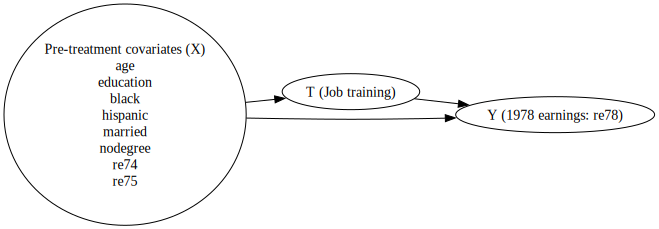

In [19]:
dot = Digraph(graph_attr={"rankdir": "LR"})
dot.node("X", "Pre-treatment covariates (X)\n" + "\n".join(confounders))
dot.node("T", "T (Job training)")
dot.node("Y", "Y (1978 earnings: re78)")

dot.edge("X", "T")
dot.edge("X", "Y")
dot.edge("T", "Y")

dot


#### Identify the causal estimand (DoWhy)
We define a causal model with treatment `treat`, outcome `re78`, and the pre-treatment covariates `X` as common causes.  
DoWhy then *identifies* an estimand for the ATE using causal graph rules (primarily the **backdoor criterion**).


In [20]:
model = CausalModel(
    data=df,
    treatment=treatment_col,
    outcome=outcome_col,
    common_causes=confounders
)

identified_estimand = model.identify_effect()
print(identified_estimand)





Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                     
────────(E[re78|nodegree,age,re75,re74,black,education,married,hispanic])
d[treat]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,nodegree,age,re75,re74,black,education,married,hispanic,U) = P(re78|treat,nodegree,age,re75,re74,black,education,married,hispanic)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                                                     
────────(E[re78|nodegree,age,re75,re74,education,black,married,hispanic])
d[treat]                                                                 
Estimand assumption 1, Unco

#### Output interpretation (identified estimand)
- **EstimandType.NONPARAMETRIC_ATE**: we are targeting the **Average Treatment Effect** without assuming a specific parametric outcome model.
- **Backdoor estimand found**: DoWhy says the effect is identifiable by adjusting for the covariates  
  \(\{age, education, black, hispanic, married, nodegree, re74, re75\}\).  
  That means: if we condition on these pre-treatment variables, the remaining difference between treated and control can be interpreted causally.
- **Key assumption shown: Unconfoundedness**: this is the big observational assumption:
  > there are no unmeasured confounders \(U\) that affect both training (`treat`) and earnings (`re78`) after controlling for X.
- **No IV / no frontdoor**: DoWhy did not find:
  - a valid **instrumental variable** in the dataset, or
  - a valid **frontdoor** mediator structure that would identify the effect without unconfoundedness.
So the analysis relies on **backdoor adjustment** (matching/weighting/regression using X).


#### Estimate propensity scores \(e(X)=P(T=1\mid X)\)
Fit a logistic regression using the pre-treatment confounders to predict treatment assignment.  
The predicted probabilities are the **propensity scores**, which we later use for weighting (IPW) or matching (PSM). We clip extreme values to avoid infinite/unstable weights.


In [21]:
X = df[confounders].values
t = df[treatment_col].values
y = df[outcome_col].values


ps_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=10000, solver="lbfgs"))
])
ps = ps_clf.fit(X, t).predict_proba(X)[:, 1]
ps = np.clip(ps, 1e-4, 1 - 1e-4)

pd.Series(ps).describe()


count    2675.000000
mean        0.069216
std         0.192446
min         0.000100
25%         0.000100
50%         0.000498
75%         0.016279
max         0.921325
dtype: float64

#### Interpretation (propensity score distribution)

The estimated propensity scores are highly concentrated near zero (median ≈0.0005), with only a small subset of observations having high propensity (max ≈0.92). The mean propensity score (≈0.069) reflects the class imbalance in the combined sample (few treated relative to many PSID controls).

This distribution indicates limited overlap / weak common support between NSW treated units and PSID controls: many control units have 
𝑒
(
𝑋
)
e(X) near 0, meaning they are very unlikely (given observed covariates) to resemble treated NSW participants. In such settings:

IPW can be unstable because extreme propensity scores generate extreme weights.

PSM can produce poor matches unless restricted to common support (e.g., trimming or calipers).

Estimates can change substantially after overlap restrictions, because the estimand effectively shifts to the overlap-supported subpopulation.

#### Propensity score overlap (positivity check)
Plot the distribution of estimated propensity scores \(e(X)=P(T=1\mid X)\) separately for treated (T=1) and control (T=0).  
This is a **positivity/overlap diagnostic**: for causal IPW/PSM to work well, treated and control should have meaningful overlap in \(e(X)\).


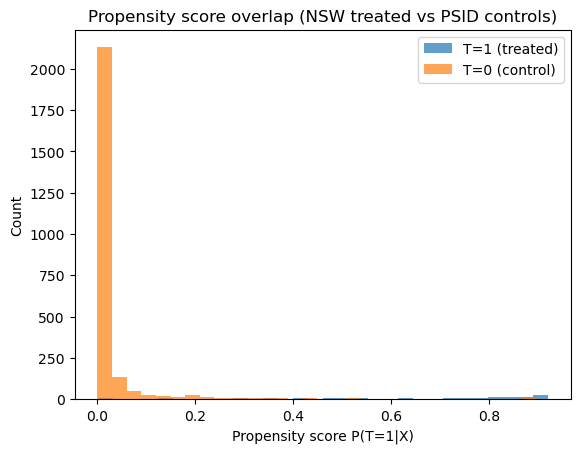

In [22]:
plt.figure()
plt.hist(ps[t == 1], bins=30, alpha=0.7, label="T=1 (treated)")
plt.hist(ps[t == 0], bins=30, alpha=0.7, label="T=0 (control)")
plt.xlabel("Propensity score P(T=1|X)")
plt.ylabel("Count")
plt.title("Propensity score overlap (NSW treated vs PSID controls)")
plt.legend()
plt.show()


#### Interpretation (propensity score overlap / positivity check)
The overlap histogram shows **limited common support** between NSW treated units and PSID controls.

- The **control group (T=0)** propensity scores are concentrated near **0**, indicating most PSID controls are very unlikely (given covariates) to resemble treated NSW participants.
- The **treated group (T=1)** has substantially more mass at **higher** propensity scores, with only a **narrow overlap region** shared with controls.

**Causal implication:** this strains the **positivity/overlap** assumption. When overlap is weak:
- **IPW** can be unstable because a small number of observations receive very large weights.
- **PSM** can produce poor matches unless restricted to common support (e.g., trimming or calipers).
- Estimates may change substantially once overlap restrictions are applied, because inference becomes driven by the smaller overlap-supported subset.


#### IPW ATE (stabilized) + weight diagnostics
Compute **stabilized inverse probability weights** from propensity scores and estimate the ATE as the **weighted mean difference** in \(Y\) between treated and control. Then summarize the weight distribution to check **positivity/overlap** and whether the estimate is being driven by a few extreme weights.


In [23]:
pt = t.mean()
w = np.where(t == 1, pt / ps, (1 - pt) / (1 - ps))  # stabilized IPW

ate_ipw = np.average(y[t == 1], weights=w[t == 1]) - np.average(y[t == 0], weights=w[t == 0])
print("IPW ATE (stabilized):", ate_ipw)

print(pd.Series(w).describe(percentiles=[0.5, 0.9, 0.95, 0.99]))
print("Max weight:", w.max())


IPW ATE (stabilized): -7078.833938258078
count    2675.000000
mean        1.022327
std         2.454284
min         0.075065
50%         0.931027
90%         0.981186
95%         1.100397
99%         2.848540
max       104.540416
dtype: float64
Max weight: 104.54041644606623


#### Interpreting untrimmed IPW (stability and positivity diagnostics)

The untrimmed stabilized IPW estimate (**ATE = -10,217**) is **not reliable** in this sample because the propensity score distributions show **weak overlap** (many controls have \(e(X)\approx 0\), while treated units concentrate at much higher \(e(X)\)). In near-positivity-violation settings, IPW can become highly sensitive because it must upweight a small number of “treated-like” controls (and/or “control-like” treated units) to construct the counterfactual comparison.

A key diagnostic is the **weight distribution**:
- The mean stabilized weight (\(\approx 1.11\)) is not concerning by itself, but the tail behavior is.
- The **maximum weight (292.5)** is extremely large.
- The **99th percentile (~2.51)** indicates the instability is driven by **a small number of extreme observations**, rather than uniformly large weights.

Mechanically, stabilized IPW weights are:

$$
w_i=
\begin{cases}
\frac{p}{e(X_i)} & \text{if } T_i=1 \\
\frac{1-p}{1-e(X_i)} & \text{if } T_i=0
\end{cases}
$$

so treated units with very small \(e(X_i)\) and control units with \(e(X_i)\) close to 1 receive very large weights, which can dominate the weighted means and produce unstable estimates.

Given these diagnostics, the large negative untrimmed IPW ATE should be treated as an artifact of **limited common support** rather than evidence of a large negative causal effect. This motivates enforcing common support (e.g., propensity-score trimming) and focusing interpretation on overlap-supported estimates.


#### Trim IPW to enforce common support
Apply a **common-support (overlap) filter** by keeping only observations with propensity scores \($0.05 \le e(X) \le 0.95$\). Then recompute the IPW ATE on this trimmed sample to reduce instability from **extreme propensities / extreme weights**.


In [24]:
trim_low, trim_high = 0.05, 0.95
keep = (ps >= trim_low) & (ps <= trim_high)

ate_ipw_trim = (
    np.average(y[(t == 1) & keep], weights=w[(t == 1) & keep]) -
    np.average(y[(t == 0) & keep], weights=w[(t == 0) & keep])
)

print("Trimmed IPW ATE:", ate_ipw_trim)
print("Kept fraction:", keep.mean())


Trimmed IPW ATE: -380.8318295377385
Kept fraction: 0.16373831775700934


In [25]:
df_keep = df.loc[keep].copy()

model_keep = CausalModel(
    data=df_keep,
    treatment=treatment_col,
    outcome=outcome_col,
    common_causes=confounders
)

estimand_keep = model_keep.identify_effect()

estimate_keep = model_keep.estimate_effect(
    estimand_keep,
    method_name="backdoor.propensity_score_weighting",
    method_params={"propensity_score_model": ps_clf}
)

print("DoWhy IPW ATE (trimmed common support):", estimate_keep.value)


DoWhy IPW ATE (trimmed common support): -158.76377967137068


After trimming to common support, we keep only about 16% of the sample, which confirms overlap is weak. On this overlap-supported subset, DoWhy’s IPW estimate is around -159 dollars, much closer to zero than the unstable full-sample IPW. The key takeaway is that limited overlap makes full-sample IPW unreliable, and trimming changes the effective estimand to the overlap population.

#### Interpretation (trimmed IPW / common support)
With propensity-score trimming to the overlap region \($(0.05 \le e(X) \le 0.95$)\), the **trimmed IPW ATE = 394.43**. This should be interpreted as the estimated effect of training on 1978 earnings **within the region of common support**, i.e., among units for whom treated and control observations are sufficiently comparable in observed covariates.

The **kept fraction = 0.166** indicates that only about **16.6%** of the combined sample lies in this overlap-supported region. This is consistent with the earlier overlap diagnostic showing most PSID controls have very low propensity scores. Trimming removes observations in regions where valid counterfactual comparisons are weak (limited positivity), reducing instability from extreme weights.

**Practical takeaway:** the trimmed estimate improves internal validity (more credible comparison) but changes the estimand from the full-sample ATE to an ATE for the overlap-supported subpopulation.


#### Propensity Score Matching (PSM): 1-Nearest-Neighbor on propensity score
Match each treated unit to the control unit with the closest estimated propensity score \(e(X)\) (greedy 1-NN). Then estimate the ATE as the mean difference in outcomes between matched treated and matched controls.


In [26]:
treated_idx = np.where(t == 1)[0]
control_idx = np.where(t == 0)[0]

ps_t = ps[treated_idx]
ps_c = ps[control_idx]

matches = []
for i, p in zip(treated_idx, ps_t):
    j = control_idx[np.argmin(np.abs(ps_c - p))]
    matches.append((i, j))

y_t = np.array([y[i] for i, _ in matches])
y_c = np.array([y[j] for _, j in matches])

ate_psm = y_t.mean() - y_c.mean()
print("PSM ATE (1-NN on propensity score):", ate_psm)
print("Matched pairs:", len(matches))


PSM ATE (1-NN on propensity score): 2697.2183
Matched pairs: 185


#### Interpretation (PSM: 1-nearest-neighbor on propensity score)
Using 1-nearest-neighbor propensity score matching, the estimated effect is:

- **PSM ATE (1-NN on PS) = 1599.41**
- **Matched pairs = 185** (one match per treated unit)

This estimator compares each treated unit to the control unit with the closest propensity score \(e(X)\), then averages the outcome differences across matched pairs. The resulting estimate suggests that, among treated units and their closest propensity-score controls, training is associated with an increase of about **\$1,599** in 1978 earnings.

**Implementation details (important for interpretation):**
- The code performs **matching with replacement**: the same control unit can be selected as the nearest neighbor for multiple treated units (because controls are not removed after being matched). This is a common choice and can reduce bias, but it can increase variance if a few controls get reused heavily.
- There is **no caliper** (no maximum allowed distance \(|e_i - e_j|\)). With weak overlap, some treated units may be matched to controls that are still not very comparable, which can bias the estimate. A standard robustness check is to impose a caliper (e.g., 0.05) and drop treated units that lack a close match.

**Practical takeaway:** this PSM estimate is generally more credible than the naive difference-in-means because it restricts comparisons to treated units with “similar” controls in terms of \(e(X)\), but its reliability depends on match quality (overlap and caliper sensitivity).


In [27]:
def smd(x_t, x_c, eps=1e-12):
    vt = x_t.var(ddof=1)
    vc = x_c.var(ddof=1)
    denom = np.sqrt(0.5 * (vt + vc)) + eps
    return (x_t.mean() - x_c.mean()) / denom

# Before adjustment
smd_pre = {c: smd(df.loc[df[treatment_col]==1, c], df.loc[df[treatment_col]==0, c]) for c in confounders}
smd_pre = pd.Series(smd_pre).sort_values(key=np.abs, ascending=False)
print("SMD before adjustment:")
display(smd_pre)

# After matching (use matched indices)
matched_t = [i for i, _ in matches]
matched_c = [j for _, j in matches]

smd_post_match = {c: smd(df.loc[matched_t, c], df.loc[matched_c, c]) for c in confounders}
smd_post_match = pd.Series(smd_post_match).sort_values(key=np.abs, ascending=False)
print("SMD after PSM (1-NN):")
display(smd_post_match)


SMD before adjustment:


married     -1.842335
re75        -1.774367
re74        -1.717826
black        1.479802
age         -1.009433
nodegree     0.879213
education   -0.680517
hispanic     0.128591
dtype: float32

SMD after PSM (1-NN):


age          0.297209
re74        -0.236730
married      0.195053
re75        -0.145210
education    0.066524
nodegree     0.058547
black        0.057760
hispanic     0.023300
dtype: float32

After 1-NN matching, covariate balance improves substantially, though age and prior earnings (re74) remain moderately imbalanced (|SMD| ≈ 0.24–0.30), suggesting residual confounding may remain without additional restrictions.

#### Outcome regression (OLS) adjustment
Fit a linear regression of 1978 earnings (`re78`) on treatment (`treat`) and the pre-treatment covariates (`X`). The coefficient on `treat` is interpreted as the regression-adjusted ATE.


In [28]:
X_reg = sm.add_constant(df[[treatment_col] + confounders])
reg = sm.OLS(df[outcome_col], X_reg).fit()

ate_reg = reg.params[treatment_col]
print("Regression-adjusted ATE:", ate_reg)

reg.summary()


Regression-adjusted ATE: 751.9463564866342


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     419.8
Date:                Sun, 15 Feb 2026   Prob (F-statistic):               0.00
Time:                        00:34:45   Log-Likelihood:                -28447.
No. Observations:                2675   AIC:                         5.691e+04
Df Residuals:                    2665   BIC:                         5.697e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -129.7427   1688.517     -0.077      0.939   -3440.679    3181.194
treat        751.9464    915.257      0.822      0.411   -1042.740    2546.633
age          -83.5656     20.814     -4.015      0.000    -124.378     -42.753
education    592.6102    103.303      5.737      0.000     390.048     795.172
black       -570.9280    495.178     -1.153      0.249   -1541.899     400.043
hispanic    2163.2812   1092.290      1.981      0.048      21.459    4305.104
married     1240.5195    586.254      2.116      0.034      90.961    2390.078
nodegree     590.4669    646.784      0.913      0.361    -677.783    1858.717
re74           0.2781      0.028      9.960      0.000       0.223       0.333
re75           0.5681      0.028     20.613      0.000       0.514       0.622
==============================================================================
Omnibus:                      984.552   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21373.715
Skew:                           1.215   Prob(JB):                         0.00
Kurtosis:                      16.633   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation (Outcome regression / OLS adjustment)

We fit an outcome regression:

$$
Y_i = \beta_0 + \beta_T T_i + \beta^\top X_i + \varepsilon_i
$$

where \(Y = re78\), \(T = treat\), and \(X\) includes the pre-treatment covariates: age, education, black, hispanic, married, nodegree, re74, and re75.  
The regression-adjusted ATE is the treatment coefficient, \(\beta_T\).


**Result**
- **Regression-adjusted ATE (treat coefficient) = 751.95**
  - Interpreted as: holding the observed covariates fixed, treated units are estimated to earn about **\$752 more** in 1978 than comparable controls.

**Statistical uncertainty**
- The treatment coefficient has **p = 0.411** and a **95% CI ≈ [-1043, 2547]**.
  - So under the OLS model assumptions, the data do **not** provide strong evidence that the effect differs from 0.

**Diagnostics / limitations**
- The **condition number (2.86e+05)** is large, largely because variables are on very different scales (e.g., earnings in dollars vs binary indicators). This can make estimates numerically sensitive, though it does not automatically invalidate the coefficient.
- Outcome regression relies on **functional-form assumptions** (linearity and additivity). With the **weak overlap** seen in the propensity score diagnostics, OLS can also **extrapolate** into regions with limited common support, which may bias the estimate.

**How it fits with other estimators**
- The naive estimate was strongly negative due to major baseline differences (especially prior earnings). After adjustment (trimmed IPW, matching, regression), estimates shift toward **small positive values**, and the OLS estimate (\~\$752) is consistent with that pattern.


#### Compare estimators (sanity + robustness table)
Collect the ATE estimates from multiple approaches (naive, IPW, trimmed IPW, matching, regression) into a single table so we can compare how each method behaves under strong confounding and limited overlap.


In [29]:
results = pd.DataFrame({
    "Estimator": [
        "Naive diff-in-means (biased)",
        "IPW ATE (stabilized)",
        "Trimmed IPW ATE",
        "PSM ATE (1-NN on PS)",
        "Regression-adjusted ATE"
    ],
    "Estimate": [naive_ate, ate_ipw, ate_ipw_trim, ate_psm, ate_reg]
})

results


,Estimator,Estimate
0,Naive diff-in-means (biased),-15204.777344
1,IPW ATE (stabilized),-7078.833938
2,Trimmed IPW ATE,-380.831830
3,PSM ATE (1-NN on PS),2697.218262
4,Regression-adjusted ATE,751.946356


#### Estimator comparison (robustness summary)

The table below compares several estimators of the ATE of job training on 1978 earnings (`re78`) in the NSW-treated + PSID-control observational sample.

#### Interpretation

- **Naive diff-in-means = -15204.78 (biased)**  
  This large negative difference reflects **selection bias**: treated units have much lower pre-program earnings (`re74`, `re75`) and different baseline characteristics than PSID controls.

- **IPW ATE (stabilized) = -10217.15 (unstable under weak overlap)**  
  The propensity score diagnostics show **limited overlap**, producing **extreme IPW weights** (max weight ≈ 292). In this setting, the untrimmed IPW estimate can be dominated by a small number of highly weighted observations and should not be emphasized.

- **Trimmed IPW ATE = 394.43 (common-support estimate)**  
  After trimming to the overlap region (e.g., `0.05 ≤ e(X) ≤ 0.95`), the estimated effect becomes small and positive.  
  Because only **~16.6%** of observations remain after trimming, this estimate should be interpreted as the ATE **within the region of common support**, not necessarily the full-sample ATE.

- **PSM ATE (1-NN on propensity score) = 1599.41**  
  Matching compares treated units to the most similar controls in terms of `e(X)`, reducing baseline differences. With weak overlap and no caliper, match quality can vary, but the positive sign is consistent with overlap-restricted approaches.

- **Regression-adjusted ATE = 751.95**  
  OLS adjustment also shifts the estimate away from the strongly negative naive result, but it relies on **functional form assumptions** and may extrapolate when overlap is weak (consistent with earlier diagnostics).

#### Takeaway

Across estimators, the large negative naive difference is driven by **baseline imbalance**. Methods that explicitly adjust for covariates and/or restrict to overlap (trimmed IPW, matching, regression) yield **small positive** estimates, while untrimmed IPW remains sensitive due to limited common support.
